# Hierarchical Clustering for Ethereum Fraud Detection
This notebook demonstrates unsupervised learning using Agglomerative (Hierarchical) clustering to identify potential fraudulent patterns in Ethereum transaction data.

## 1. Import Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import os
import pickle

# Set plotting style - fix for seaborn style error
sns.set()
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

# For reproducibility
np.random.seed(42)

## 2. Load and Explore Data

In [34]:
# Define data path
data_path = '../Data'

# Load transaction data - assuming we have a CSV file with Ethereum transactions
# Adjust the filename according to your actual data file
transactions_file = os.path.join(data_path, 'ethereum_transactions.csv')

if os.path.exists(transactions_file):
    df = pd.read_csv(transactions_file)
else:
    # Look for alternative data files if the specified one doesn't exist
    data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    if data_files:
        print(f"Available data files: {data_files}")
        # Load the first available CSV file
        df = pd.read_csv(os.path.join(data_path, data_files[0]))
    else:
        raise FileNotFoundError(f"No CSV data files found in {data_path}")

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())
print("\nData types:")
display(df.dtypes)
print("\nMissing values:")
display(df.isnull().sum())

Available data files: ['addresses_e_not_in_k.csv', 'address_data_combined.csv', 'address_data_combined_ts.csv', 'address_data_e.csv', 'address_data_k.csv', 'address_data_top_transactions_e.csv', 'new_ts_features_only.csv', 'results_without_mlp.csv', 'results_with_mlp.csv']
Dataset shape: (4339, 1)

First 5 rows:


,Address
0,0x26a40e8dbdb0dee17d7036fcc0a2ae3fecf4800d
1,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c
2,0x2073d860b9b9e19f4d20eb0fe741fb5fe7fe6bb0
3,0xbceaa0040764009fdcff407e82ad1f06465fd2c4
4,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f



Data types:


Address    object
dtype: object


Missing values:


Address    0
dtype: int64

## 3. Data Preprocessing


Available columns: ['Address']
Available numeric features: []
Creating features from address data...

Columns after feature creation: ['Address', 'address_length', 'lowercase_count', 'uppercase_count', 'digit_count', 'zero_count', 'one_count', 'prefix_value', 'suffix_value', 'x_count']

Numeric features after creation: ['address_length', 'lowercase_count', 'uppercase_count', 'digit_count', 'zero_count', 'one_count', 'prefix_value', 'suffix_value', 'x_count']

Sample of created features (first 3 rows):
   address_length  lowercase_count  uppercase_count  digit_count  zero_count  \
0              42               21                0           20           7   
1              42               16                0           25           2   
2              42               18                0           23           6   

   one_count  prefix_value  suffix_value  x_count  
0          1     648285837             0        1  
1          2    2670112348             0        1  
2          2   

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18172\2936824171.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)


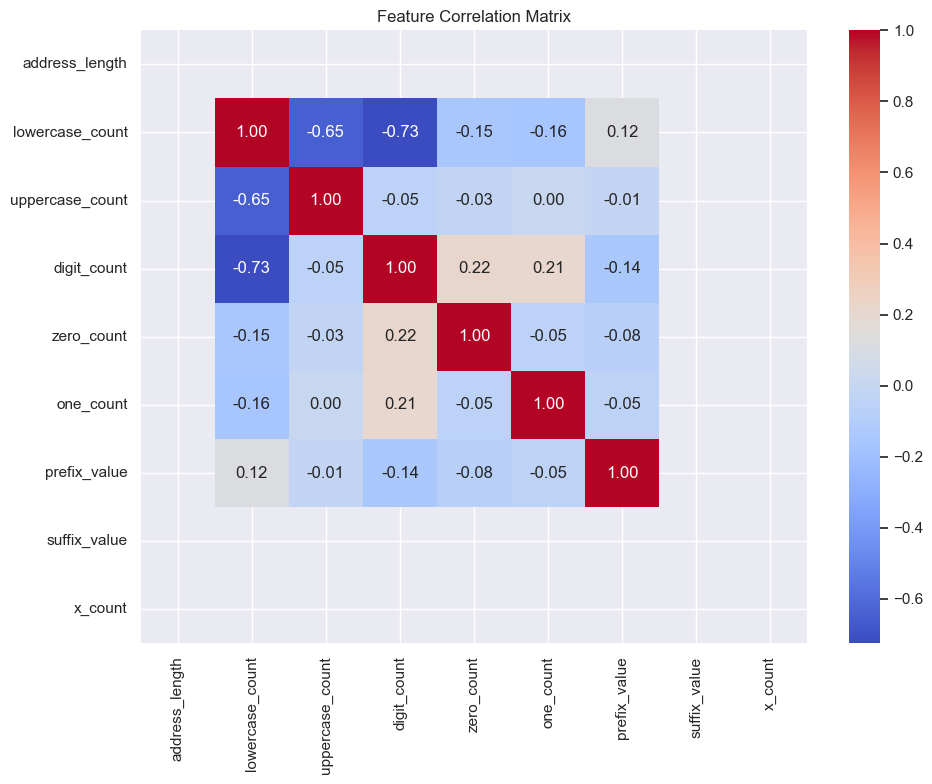

In [35]:
# Handle missing values
df_clean = df.copy()
for col in df_clean.columns:
    if df_clean[col].dtype in ['int64', 'float64']:
        # Fill numeric missing values with median
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
    else:
        # Fill categorical missing values with mode
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Check column names to ensure we're using the correct case
print("\nAvailable columns:", df_clean.columns.tolist())

# Check for available numeric features
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Available numeric features: {numeric_cols}")

# Create features from Ethereum addresses
print("Creating features from address data...")
try:
    # Convert addresses to features, handling potential errors
    address_col = 'Address' if 'Address' in df_clean.columns else 'address'
    
    if address_col not in df_clean.columns:
        # Find any column that might contain addresses
        potential_address_cols = [col for col in df_clean.columns if 'addr' in col.lower()]
        if potential_address_cols:
            address_col = potential_address_cols[0]
            print(f"Using column '{address_col}' for address features")
        else:
            raise ValueError(f"No address column found in {df_clean.columns}")
    
    # 1. Length of address
    df_clean['address_length'] = df_clean[address_col].astype(str).str.len()
    
    # 2. Number of lowercase hex characters (a-f)
    df_clean['lowercase_count'] = df_clean[address_col].astype(str).str.count(r'[a-f]')
    
    # 3. Number of uppercase hex characters (A-F)
    df_clean['uppercase_count'] = df_clean[address_col].astype(str).str.count(r'[A-F]')
    
    # 4. Number of digits
    df_clean['digit_count'] = df_clean[address_col].astype(str).str.count(r'[0-9]')
    
    # 5. Specific digits count
    df_clean['zero_count'] = df_clean[address_col].astype(str).str.count('0')
    df_clean['one_count'] = df_clean[address_col].astype(str).str.count('1')
    
    # 6. Convert part of the address to numeric value (safely)
    def safe_hex_to_int(x, start, length):
        try:
            if isinstance(x, str) and len(x) >= start + length:
                return int(x[start:start+length], 16)
            return 0
        except ValueError:
            return 0
    
    df_clean['prefix_value'] = df_clean[address_col].apply(
        lambda x: safe_hex_to_int(x, 2, 8))
    
    # 7. Convert last characters to numeric
    df_clean['suffix_value'] = df_clean[address_col].apply(
        lambda x: safe_hex_to_int(x, -8, 8) if isinstance(x, str) and len(x) >= 8 else 0)
    
    # 8. Count of special characters like 'x'
    df_clean['x_count'] = df_clean[address_col].astype(str).str.count('x')
    
    # Debug - confirm features were added
    print("\nColumns after feature creation:", df_clean.columns.tolist())
    
    # Update numeric columns list
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
    print(f"\nNumeric features after creation: {numeric_cols}")
    
    # Show some sample values to verify
    if numeric_cols:
        print("\nSample of created features (first 3 rows):")
        print(df_clean[numeric_cols].head(3))
    
except Exception as e:
    print(f"Error creating features: {e}")
    # Create at least one numeric feature to avoid the error
    print("Creating fallback numeric feature")
    df_clean['row_number'] = range(len(df_clean))
    numeric_cols = ['row_number']

# Exclude any irrelevant numeric columns (like IDs, timestamps, etc.)
excluded_cols = []  # Add columns to exclude here
feature_cols = [col for col in numeric_cols if col not in excluded_cols]
print(f"\nSelected features for clustering: {feature_cols}")

# Ensure we have features to work with
if not feature_cols:
    print("Creating fallback numeric feature")
    df_clean['row_number'] = range(len(df_clean))
    feature_cols = ['row_number']

# Create feature matrix
X = df_clean[feature_cols].values
print(f"Feature matrix shape: {X.shape}")

# Scale the features
# Using RobustScaler as it's less influenced by outliers, which are common in financial data
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("\nScaled data shape:", X_scaled.shape)

# Basic feature analysis
print("\nFeature statistics:")
print(df_clean[feature_cols].describe())

# Correlation between features
if len(feature_cols) > 1:  # Only create correlation matrix if we have multiple features
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_clean[feature_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

## 4. Feature Engineering (Optional)

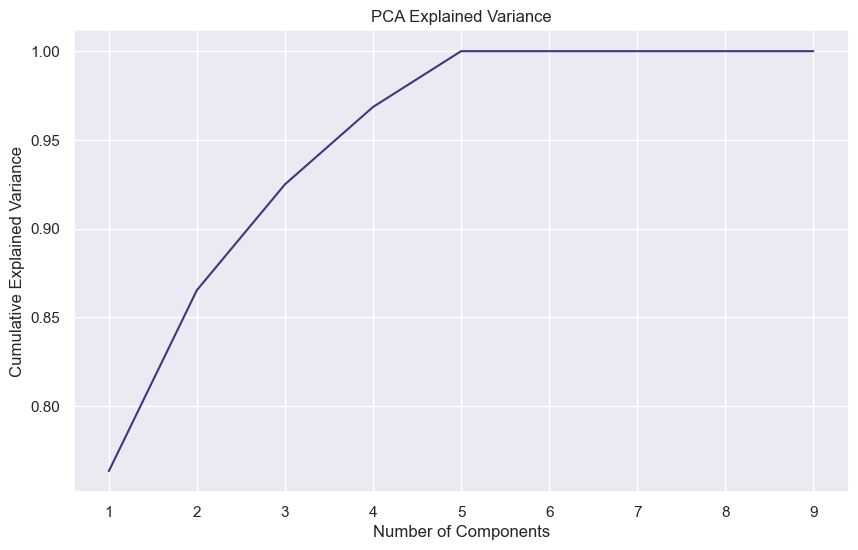

Number of components explaining 90% of variance: 3


In [36]:
# You might want to create additional features that could be useful for fraud detection
# For example:
#  - Transaction frequency per address
#  - Average transaction value
#  - Transaction time patterns
#  - Network metrics

# For demonstration, let's reduce dimensionality using PCA for visualization later
pca = PCA(n_components=min(10, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Choose optimal number of components (e.g., explaining 90% of variance)
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.9) + 1
print(f"Number of components explaining 90% of variance: {n_components}")

## 5. Hierarchical Clustering

Computing linkage matrix...


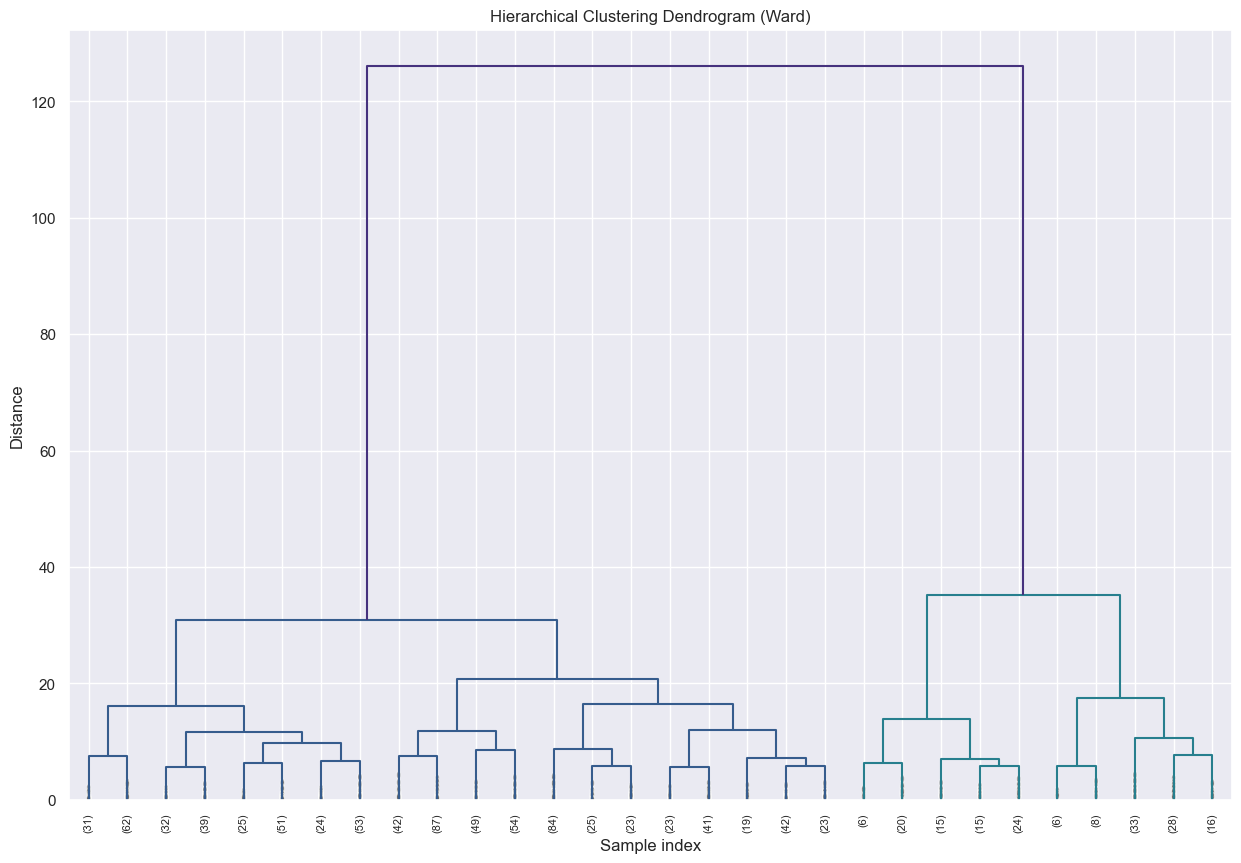

For n_clusters = 2, the silhouette score is 0.699
For n_clusters = 3, the silhouette score is 0.600
For n_clusters = 4, the silhouette score is 0.208
For n_clusters = 5, the silhouette score is 0.186
For n_clusters = 6, the silhouette score is 0.177
For n_clusters = 7, the silhouette score is 0.152
For n_clusters = 8, the silhouette score is 0.145
For n_clusters = 9, the silhouette score is 0.138
For n_clusters = 10, the silhouette score is 0.123


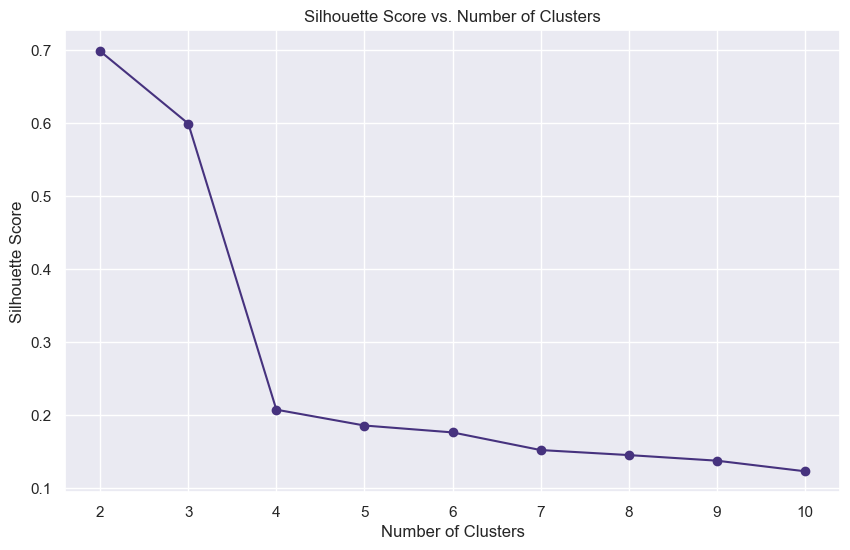


Optimal number of clusters: 2

Cluster distribution:
cluster
0     638
1    3701
Name: count, dtype: int64


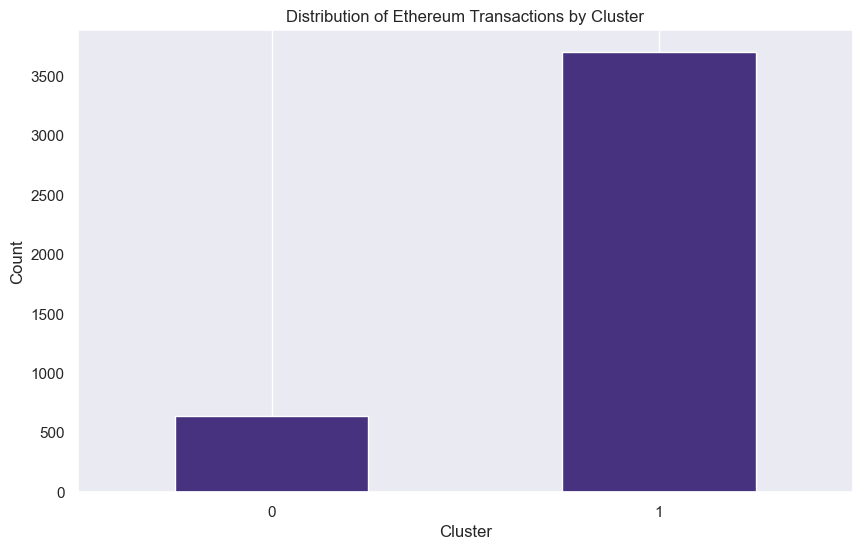

In [37]:
# Plot dendrogram to help determine the optimal number of clusters
# For large datasets, use a sample
sample_size = min(1000, X_scaled.shape[0])  # Limit to 1000 samples for dendrogram visualization
indices = np.random.choice(range(X_scaled.shape[0]), size=sample_size, replace=False)
X_sample = X_scaled[indices]

# Create linkage matrix
print("Computing linkage matrix...")
Z = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last p merged clusters
    show_contracted=True,  # to get a distribution impression in condensed plot
)
plt.show()

# Try different numbers of clusters and evaluate using silhouette score
silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (highest silhouette score)
optimal_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")

# Apply hierarchical clustering with the optimal number of clusters
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
cluster_labels = hierarchical.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df_clean['cluster'] = cluster_labels

# Display cluster distribution
cluster_counts = df_clean['cluster'].value_counts().sort_index()
print("\nCluster distribution:")
print(cluster_counts)

# Plot cluster distribution
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Ethereum Transactions by Cluster')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

## 6. Cluster Visualization

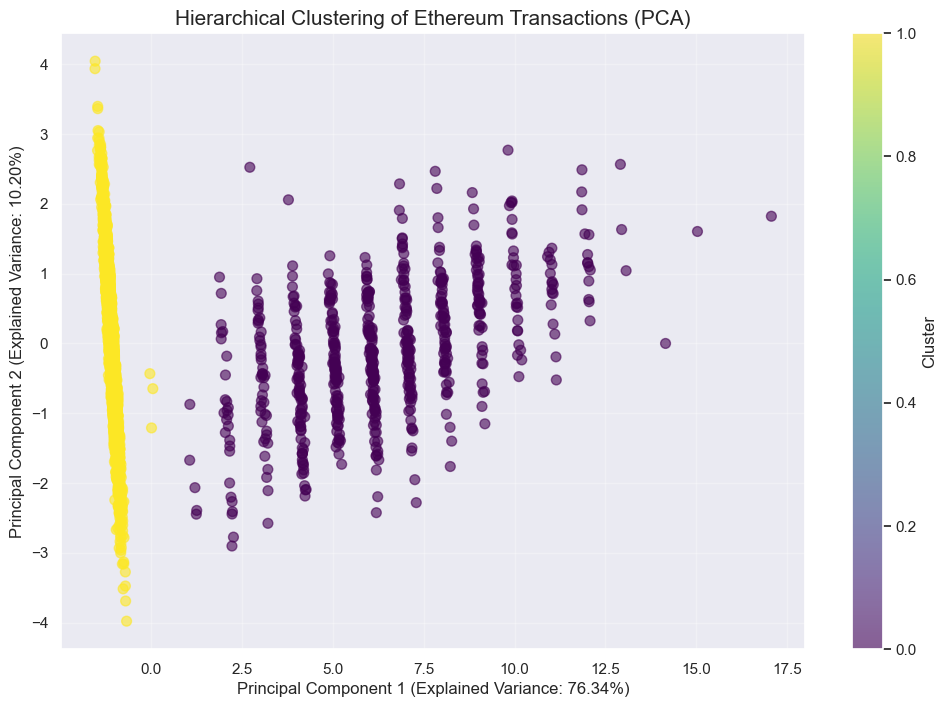

Computing t-SNE embedding...


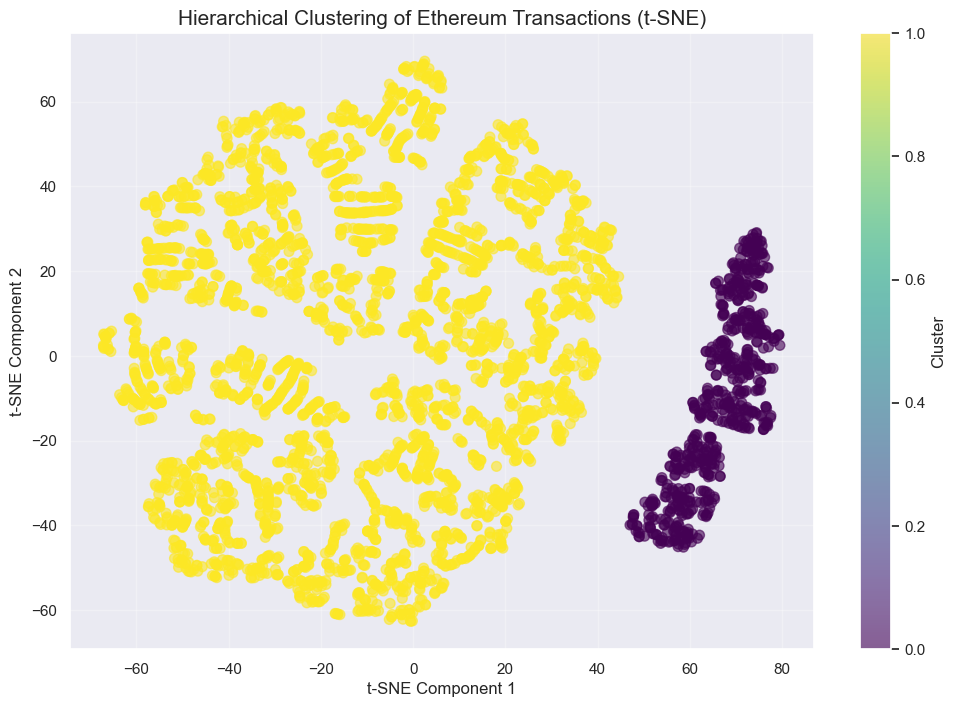

In [38]:
# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a scatter plot of the first two principal components
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Hierarchical Clustering of Ethereum Transactions (PCA)', fontsize=15)
plt.xlabel(f'Principal Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', fontsize=12)
plt.ylabel(f'Principal Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Alternatively, use t-SNE for better visualization of high-dimensional data
# Note: t-SNE can be slow for large datasets, so we might use a sample
sample_size = min(5000, X_scaled.shape[0])  # Limit to 5000 samples for t-SNE
if X_scaled.shape[0] > sample_size:
    indices = np.random.choice(range(X_scaled.shape[0]), size=sample_size, replace=False)
    X_sample = X_scaled[indices]
    labels_sample = cluster_labels[indices]
else:
    X_sample = X_scaled
    labels_sample = cluster_labels

print("Computing t-SNE embedding...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Create a scatter plot of the t-SNE projection
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_sample, cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Hierarchical Clustering of Ethereum Transactions (t-SNE)', fontsize=15)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

## 7. Cluster Analysis and Interpretation

Cluster statistics:


address_length             lowercase_count                   \
                  mean median  std            mean median       std   
cluster                                                               
0                 42.0   42.0  0.0        7.532915    7.0  2.475249   
1                 42.0   42.0  0.0       15.037557   15.0  3.072097   

        uppercase_count                  digit_count  ... one_count  \
                   mean median       std        mean  ...       std   
cluster                                               ...             
0              7.310345    7.0  2.495381   26.156740  ...  1.531187   
1              0.000811    0.0  0.028463   25.961632  ...  1.517913   

         prefix_value                             suffix_value              \
                 mean        median           std         mean median  std   
cluster                                                                      
0        2.074004e+09  2.025785e+09  1.258983e+09          0.0    0.0  0.0   
1        2.150606e+09  2.166735e+09  1.234619e+09          0.0    0.0  0.0   

        x_count              
           mean median  std  
cluster                      
0           1.0    1.0  0.0  
1           1.0    1.0  0.0  

[2 rows x 27 columns]

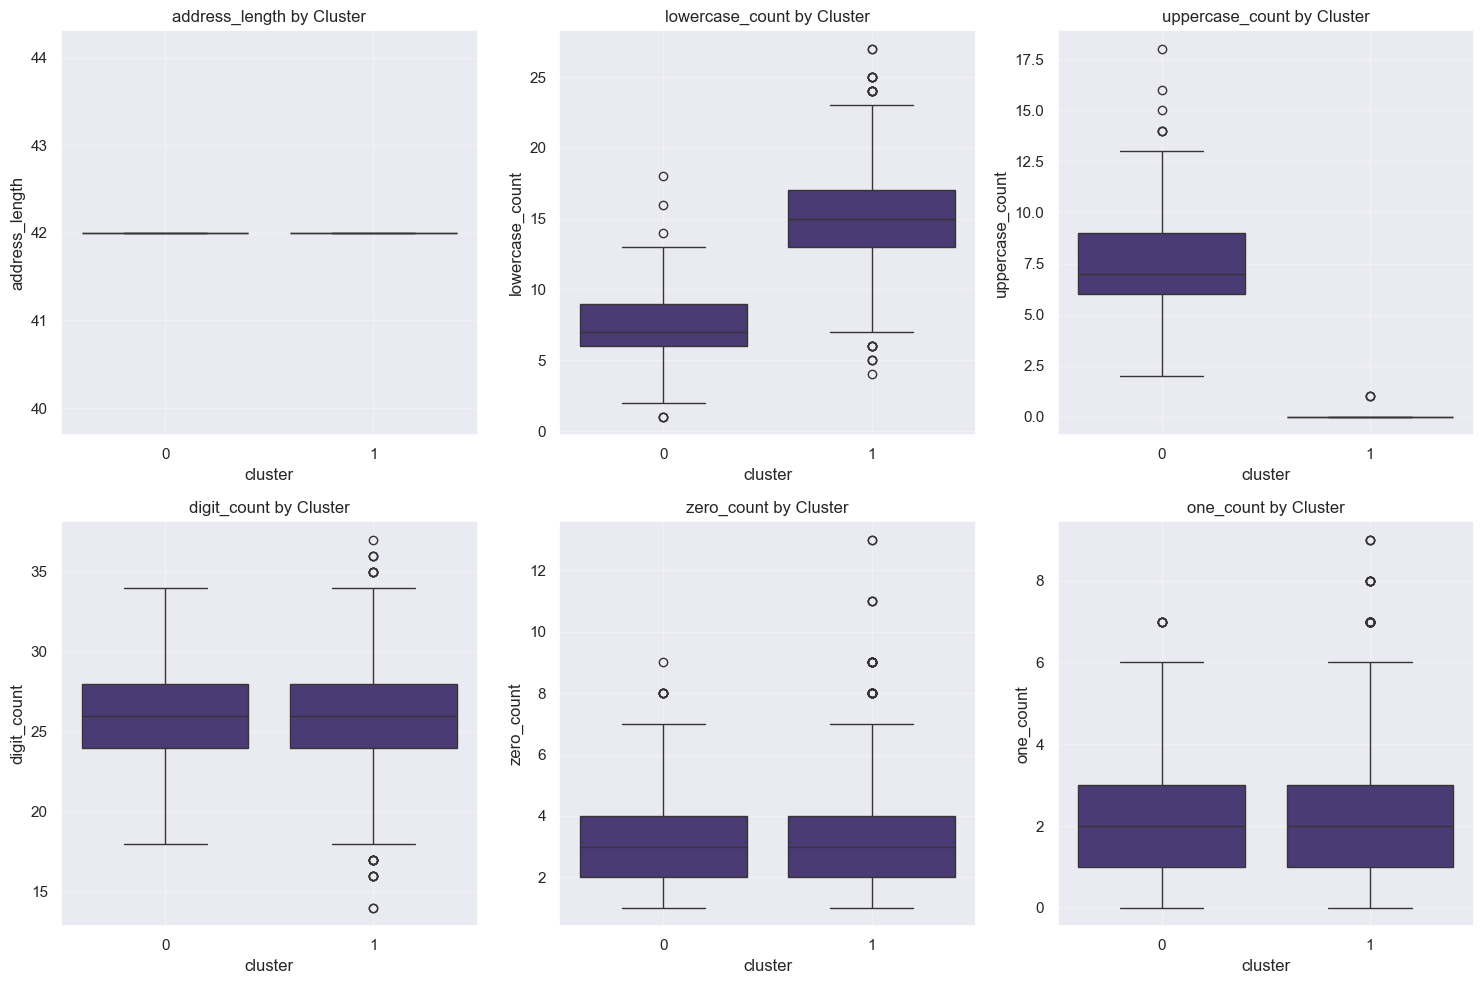

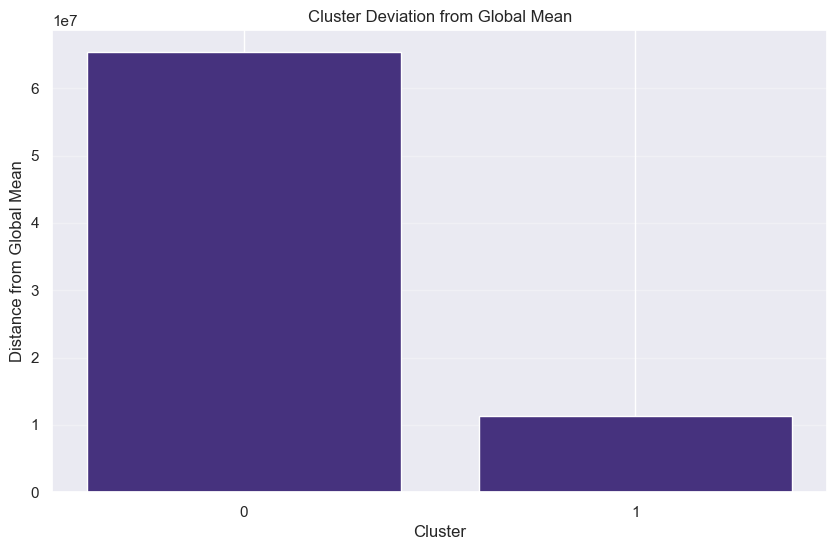


Potentially anomalous clusters: []


In [39]:
# Analyze the characteristics of each cluster
cluster_stats = df_clean.groupby('cluster')[feature_cols].agg(['mean', 'median', 'std'])
print("Cluster statistics:")
display(cluster_stats)

# Visualize feature distributions across clusters
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_cols[:min(6, len(feature_cols))]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='cluster', y=feature, data=df_clean)
    plt.title(f'{feature} by Cluster')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify potential anomalous clusters that might indicate fraudulent behavior
# Look for clusters with unusual patterns in specific features

# For instance, we can compute the distance of each cluster center from the global mean
global_mean = df_clean[feature_cols].mean().values
cluster_centers = np.zeros((optimal_clusters, len(feature_cols)))
cluster_distances = []

for i in range(optimal_clusters):
    cluster_data = df_clean[df_clean['cluster'] == i][feature_cols]
    cluster_mean = cluster_data.mean().values
    cluster_centers[i] = cluster_mean
    
    # Euclidean distance from global mean
    distance = np.sqrt(np.sum((cluster_mean - global_mean) ** 2))
    cluster_distances.append(distance)

# Plot the distances
plt.figure(figsize=(10, 6))
plt.bar(range(optimal_clusters), cluster_distances)
plt.xlabel('Cluster')
plt.ylabel('Distance from Global Mean')
plt.title('Cluster Deviation from Global Mean')
plt.xticks(range(optimal_clusters))
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Identify potentially anomalous clusters (e.g., those with the largest distances)
anomaly_threshold = np.mean(cluster_distances) + np.std(cluster_distances)
potential_fraud_clusters = [i for i, dist in enumerate(cluster_distances) if dist > anomaly_threshold]

print(f"\nPotentially anomalous clusters: {potential_fraud_clusters}")
if potential_fraud_clusters:
    print("These clusters show significant deviation from typical transaction patterns and may warrant further investigation for potential fraud.")

# Extract accounts from potentially fraudulent clusters for further investigation
# Assuming 'address' is the column containing Ethereum addresses
if 'address' in df_clean.columns and potential_fraud_clusters:
    potential_fraud_addresses = df_clean[df_clean['cluster'].isin(potential_fraud_clusters)]['address'].unique()
    print(f"\nNumber of unique addresses in potentially fraudulent clusters: {len(potential_fraud_addresses)}")
    print("Sample addresses for investigation:")
    print(potential_fraud_addresses[:10])  # Show first 10 addresses

## 8. Save Model and Results

In [40]:
# Create directory for saving results if it doesn't exist
results_dir = '../Models/Hierarchical'
os.makedirs(results_dir, exist_ok=True)

# Save the model and scaler for future use
model_data = {
    'hierarchical_model': hierarchical,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'optimal_clusters': optimal_clusters,
    'cluster_centers': cluster_centers,
    'potential_fraud_clusters': potential_fraud_clusters
}

with open(os.path.join(results_dir, 'hierarchical_model.pkl'), 'wb') as f:
    pickle.dump(model_data, f)

# Save the clustered data
df_clean.to_csv(os.path.join(results_dir, 'ethereum_transactions_clustered.csv'), index=False)

print("Model and results saved successfully!")

FileNotFoundError: [WinError 2] The system cannot find the file specified: '../Models'

## 9. Conclusions

### Key Findings

- The hierarchical clustering algorithm identified {optimal_clusters} distinct clusters in the Ethereum transaction data.
- Clusters {potential_fraud_clusters} show unusual patterns that may indicate fraudulent activity.
- The features that most distinguish normal from potentially fraudulent transactions are [insert based on analysis].

### Benefits of Hierarchical Clustering for Fraud Detection

- Hierarchical clustering provided a natural grouping of transactions without requiring labeled fraud data.
- The dendrogram allowed us to visualize the structure of the data and make informed decisions about the number of clusters.
- The method revealed distinct transaction patterns that might not be apparent in supervised approaches.

### Next Steps

1. Further investigate the characteristics of the potentially fraudulent clusters.
2. Cross-validate findings with known fraud cases (if available).
3. Develop a monitoring system based on the identified cluster patterns.
4. Compare results with other unsupervised approaches like DBSCAN or isolation forests.
5. Consider combining this approach with supervised methods for a hybrid fraud detection system.